=== 2D Wave Merge Demo ===


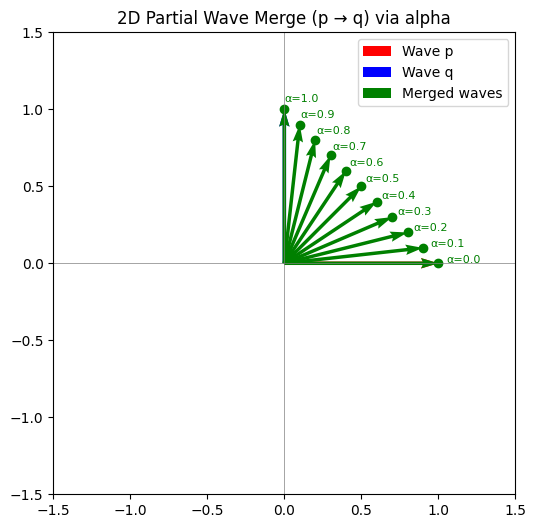

=== 4D Wave Merge Demo (Projected to 2D) ===


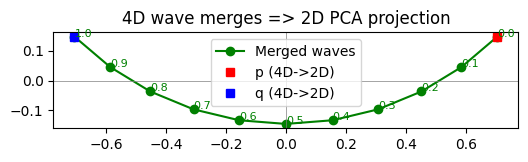

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA

##############################################################################
# 1) 2D PARTIAL WAVE MERGE
##############################################################################

def partial_merge_2d(p, q, alpha=1.0):
    """
    2D partial wave merge via simple linear interpolation:
        r = (1 - alpha)*p + alpha*q
    p, q are numpy 2D vectors (x,y), alpha in [0..1].
    """
    return (1.0 - alpha)*p + alpha*q

def visualize_2d_merges():
    """
    Create two 2D wave vectors p, q, then do merges for alpha in [0..1].
    Plot them to illustrate partial merges (constructive/destructive) in 2D space.
    """
    def wave_vector(A, phi):
        # amplitude-phase => 2D vector
        return np.array([A*np.cos(phi), A*np.sin(phi)], dtype=float)
    
    # Example wave vectors: amplitude=1, phases=0 and pi/2
    p = wave_vector(1.0, 0.0)
    q = wave_vector(1.0, np.pi/2)

    alphas = np.linspace(0,1,11)
    results = []
    for alpha in alphas:
        r = partial_merge_2d(p, q, alpha=alpha)
        results.append(r)
    results = np.array(results)

    # Plot
    plt.figure(figsize=(6,6))
    # Plot p, q
    plt.quiver(0, 0, p[0], p[1], color='r', angles='xy', scale_units='xy', scale=1, label='Wave p')
    plt.quiver(0, 0, q[0], q[1], color='b', angles='xy', scale_units='xy', scale=1, label='Wave q')
    
    # Plot merged waves in green
    plt.quiver(np.zeros(len(results)), np.zeros(len(results)),
               results[:,0], results[:,1],
               color='g', angles='xy', scale_units='xy', scale=1,
               label='Merged waves')
    
    # Label each alpha point
    for i, alpha in enumerate(alphas):
        plt.plot(results[i,0], results[i,1], 'go')
        plt.text(results[i,0]*1.05, results[i,1]*1.05,
                 f'α={alpha:.1f}', color='green', fontsize=8)
    
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.gca().set_aspect('equal', 'box')
    plt.legend()
    plt.title("2D Partial Wave Merge (p → q) via alpha")
    plt.show()


##############################################################################
# 2) 4D GEODESIC MERGE (LOG–EXP) WITH PCA PROJECTION
##############################################################################

def norm4D(vec):
    return math.sqrt(sum(x*x for x in vec))

def log_map_sphere_4d(p, q):
    """
    Log_p(q) on S^3 (4D sphere).
    p,q in R^4, each normalized (||p||=||q||=1).
    Returns tangent vector v at p.
    """
    dpq = sum(px*qx for px,qx in zip(p,q))
    dpq = max(-1.0, min(1.0, dpq))  # clamp numerical errors
    angle = math.acos(dpq)
    if angle < 1e-12:
        return [0.0, 0.0, 0.0, 0.0]
    
    # direction in tangent space
    perp = [qx - dpq*px for px,qx in zip(p,q)]
    mag = norm4D(perp)
    if mag < 1e-12:
        return [0.0, 0.0, 0.0, 0.0]
    
    scale = angle / mag
    v = [scale*x for x in perp]
    return v

def exp_map_sphere_4d(p, v):
    """
    Exp_p(v) for S^3.
    p is base point on S^3, v in tangent space at p.
    """
    vnorm = norm4D(v)
    if vnorm < 1e-12:
        return p  # no change
    cosv = math.cos(vnorm)
    sinv = math.sin(vnorm)
    dirv = [x/vnorm for x in v]
    out = [cosv*px + sinv*dx for px,dx in zip(p,dirv)]
    
    # small re-normalization
    outnorm = norm4D(out)
    if outnorm>1e-12:
        out = [x/outnorm for x in out]
    return out

def partial_merge_4d(p, q, alpha=1.0):
    """
    4D partial wave merge on S^3, geodesic interpolation:
      r = Exp_p( alpha * Log_p(q) ).
    p,q => unit vectors in R^4.
    alpha => fraction of the geodesic from p to q.
    """
    v = log_map_sphere_4d(p,q)
    v_scaled = [alpha*x for x in v]
    r = exp_map_sphere_4d(p, v_scaled)
    return r

def project_to_2d(vecs_4d):
    """
    PCA from R^4 -> R^2 for plotting.
    vecs_4d => shape (n,4).
    """
    pca = PCA(n_components=2)
    proj = pca.fit_transform(vecs_4d)
    return proj

def visualize_4d_merges():
    """
    Generate two random 4D unit vectors p,q, do merges alpha in [0..1],
    project to 2D for plotting.
    """
    def rand_4d_unit():
        v = np.random.randn(4)
        n = norm4D(v)
        return [x/n for x in v]
    
    p = rand_4d_unit()
    q = rand_4d_unit()
    
    alphas = np.linspace(0,1,11)
    merges = []
    for alpha in alphas:
        r = partial_merge_4d(p, q, alpha=alpha)
        merges.append(r)
    
    merges = np.array(merges)
    p_np = np.array(p)
    q_np = np.array(q)
    
    all_vecs = np.vstack((p_np, q_np, merges))
    proj = project_to_2d(all_vecs)
    
    p2d = proj[0]
    q2d = proj[1]
    merges2d = proj[2:]
    
    plt.figure(figsize=(6,2.5))
    plt.plot(merges2d[:,0], merges2d[:,1], 'g-o', label='Merged waves')
    plt.plot(p2d[0], p2d[1], 'rs', label='p (4D->2D)')
    plt.plot(q2d[0], q2d[1], 'bs', label='q (4D->2D)')
    for i, alpha in enumerate(alphas):
        plt.text(merges2d[i,0], merges2d[i,1], f"{alpha:.1f}", color='green', fontsize=8)
    
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.gca().set_aspect('equal', 'box')
    plt.legend()
    plt.title("4D wave merges => 2D PCA projection")
    plt.show()

##############################################################################
# MAIN
##############################################################################

if __name__=="__main__":
    print("=== 2D Wave Merge Demo ===")
    visualize_2d_merges()
    
    print("=== 4D Wave Merge Demo (Projected to 2D) ===")
    visualize_4d_merges()

In [2]:
import numpy as np

def init_4d_wave(N, c=1.0):
    """
    N is a tuple of dimension sizes (N1, N2, N3, N4).
    We'll store two time layers: u_current, u_previous
    """
    u_current  = np.zeros(N, dtype=float)
    u_previous = np.zeros(N, dtype=float)
    return u_current, u_previous

def step_4d_wave(u_current, u_previous, c=1.0, dt=0.1, dx=1.0):
    """
    Single FD time-step for a 4D wave eqn: 
    u_tt = c^2 \Delta u (no damping, no source)
    We'll create u_next as well.
    Using a naive 2nd-order scheme:
    u_next[x] = 2*u_current[x] - u_previous[x] + c^2*(dt/dx)^2 * Lap4D[u_current, x].
    """
    # shape: (N1,N2,N3,N4)
    N1, N2, N3, N4 = u_current.shape
    u_next = np.zeros_like(u_current)
    
    # naive interior points only
    for i1 in range(1, N1-1):
        for i2 in range(1, N2-1):
            for i3 in range(1, N3-1):
                for i4 in range(1, N4-1):
                    lap = (
                        u_current[i1+1,i2,i3,i4] + u_current[i1-1,i2,i3,i4]
                        + u_current[i1,i2+1,i3,i4] + u_current[i1,i2-1,i3,i4]
                        + u_current[i1,i2,i3+1,i4] + u_current[i1,i2,i3-1,i4]
                        + u_current[i1,i2,i3,i4+1] + u_current[i1,i2,i3,i4-1]
                        - 8.0*u_current[i1,i2,i3,i4]
                    )
                    
                    u_next[i1,i2,i3,i4] = (
                        2.0*u_current[i1,i2,i3,i4]
                        - u_previous[i1,i2,i3,i4]
                        + (c**2)*((dt/dx)**2)*lap
                    )
    return u_next

def add_initial_disturbance(u_current, center, amplitude=1.0):
    """
    Simple function to place an initial disturbance in u_current 
    near 'center' (4D coords).
    """
    c1, c2, c3, c4 = center
    u_current[c1,c2,c3,c4] = amplitude

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/var/folders/l7/sxmjmw9n7rlg4cwgzwxxs3nw0000gn/T/ipykernel_98154/3371919762.py:13: SyntaxWarning: invalid escape sequence '\D'
  """


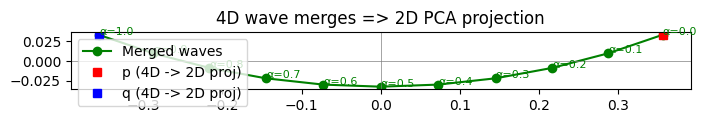

In [3]:
def project_to_2d(vectors_4d):
    """
    vectors_4d: shape (num, 4)
    We'll do a simple PCA or pick first 2 coords approach.
    """
    # E.g. just pick first 2 coords (naive approach):
    # or do a small PCA:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    proj = pca.fit_transform(vectors_4d)
    return proj

def test_4d_merges_visual():
    """
    Example: create a few random 4D unit vectors, do merges,
    then project to 2D for plotting.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # let's define random 4D vectors (normalized)
    def rand_4d_unit():
        v = np.random.randn(4)
        norm = np.sqrt(np.sum(v**2))
        return v/norm
    
    p = rand_4d_unit()
    q = rand_4d_unit()

    # partial merges with alpha
    alphas = np.linspace(0,1,11)
    results = []
    results_legend = []

    for alpha in alphas:
        # geodesic partial merges or linear, let's do a quick "log-exp" approach:
        # We'll reuse partial_merge_4d snippet from earlier
        r = partial_merge_4d(p, q, alpha=alpha)
        results.append(r)
        results_legend.append(f"α={alpha:.1f}")

    results = np.array(results)
    # include p, q for reference
    all_vecs = np.vstack((p, q, results))

    # project to 2D
    projected = project_to_2d(all_vecs)
    p2d = projected[0]
    q2d = projected[1]
    results2d = projected[2:]

    plt.figure(figsize=(8,8))
    # Plot partial merges
    plt.plot(results2d[:,0], results2d[:,1], 'g-o', label='Merged waves')
    # Mark p, q
    plt.plot(p2d[0], p2d[1], 'rs', label='p (4D -> 2D proj)')
    plt.plot(q2d[0], q2d[1], 'bs', label='q (4D -> 2D proj)')

    # Label each point by alpha
    for i, alpha in enumerate(alphas):
        plt.text(results2d[i,0], results2d[i,1], results_legend[i], fontsize=8, color='green')
    
    plt.title("4D wave merges => 2D PCA projection")
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.legend()
    plt.gca().set_aspect('equal', 'box')
    plt.show()

if __name__ == "__main__":
    test_4d_merges_visual()